In [1]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
import numpy as np
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [2]:
# Define the target measure
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        

# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [3]:
# Configure the index vectors
num_k_per_dim = 20
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
hk_list = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [ ]:
def compute_ball_fourier_and_grad_theta(xt, r, ks, L_list, hk_list):
    """
    Compute Fourier transform and gradients of a normalized ball indicator function
    where the ball is placed in theta direction from the position.

    Parameters:
    - pos_theta: (3,) array [x, y, theta]
    - r: float, radius of the ball
    - ks: (N, 2) array of wave numbers (K1, K2)
    - L_list: (2,) domain lengths [L1, L2]
    - hk_list: (N,) normalization constants

    Returns:
    - phi_k: (N,), Fourier transform coefficients
    - grad: (N, 3), gradient w.r.t. [x, y, theta]
    """
    x, y, theta = xt
    x_c = x + r * np.cos(theta)
    y_c = y + r * np.sin(theta)

    k1 = ks[:, 0] * np.pi / L_list[0]
    k2 = ks[:, 1] * np.pi / L_list[1]
    k_norm = np.sqrt(k1**2 + k2**2)
    k_norm_safe = np.where(k_norm == 0, 1e-8, k_norm)

    cos1 = np.cos(k1 * x_c)
    cos2 = np.cos(k2 * y_c)
    sin1 = np.sin(k1 * x_c)
    sin2 = np.sin(k2 * y_c)

    bessel = (2 / (r * k_norm_safe)) * j1(r * k_norm_safe)
    bessel = np.where(k_norm == 0, 1.0, bessel)

    phi_k = (bessel * cos1 * cos2) / hk_list

    # Gradients
    dphix = (-k1 * sin1 * cos2) * bessel / hk_list
    dphiy = (-k2 * cos1 * sin2) * bessel / hk_list

    # dphi/dtheta using chain rule
    dxc_dtheta = -r * np.sin(theta)
    dyc_dtheta = r * np.cos(theta)
    dphidtheta = bessel / hk_list * (
        dphix * dxc_dtheta + dphiy * dyc_dtheta
    )

    grad = np.stack([dphix, dphiy, dphidtheta], axis=0)
    return phi_k, grad

In [5]:
def gaussian_fourier(k_vec, theta, sigma1, sigma2):
    """
    Compute Fourier transform of anisotropic Gaussian centered at 0 with rotation by theta.
    """
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    Sigma = R @ np.diag([sigma1**2, sigma2**2]) @ R.T
    quad = np.einsum('ni,ij,nj->n', k_vec, Sigma, k_vec)
    return np.exp(-0.5 * quad)

def compute_convolved_ball_fourier_and_grad(xt, r, ks, L_list, hk_list, sigma1, sigma2):
    """
    Compute Fourier transform and gradient of the convolution between normalized ball and anisotropic Gaussian.
    """
    # Step 1: Ball Fourier and its gradient
    phi_k_ball, grad_ball = compute_ball_fourier_and_grad_theta(xt, r, ks, L_list, hk_list)

    # Step 2: Gaussian Fourier
    k1 = ks[:, 0] * np.pi / L_list[0]
    k2 = ks[:, 1] * np.pi / L_list[1]
    k_vec = np.stack([k1, k2], axis=1)
    gk = gaussian_fourier(k_vec, theta=xt[2], sigma1=sigma1, sigma2=sigma2)

    # Convolution in frequency = multiplication
    phi_k = phi_k_ball * gk

    # Gradient using product rule
    dphix = grad_ball[0] * gk
    dphiy = grad_ball[1] * gk

    # Derivative w.r.t. theta: includes Gaussian derivative
    # Derivative of gk w.r.t. theta
    theta = xt[2]
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    dR_dtheta = np.array([[-np.sin(theta), -np.cos(theta)],
                          [ np.cos(theta), -np.sin(theta)]])
    
    Sigma = R @ np.diag([sigma1**2, sigma2**2]) @ R.T
    dSigma_dtheta = dR_dtheta @ np.diag([sigma1**2, sigma2**2]) @ R.T + R @ np.diag([sigma1**2, sigma2**2]) @ dR_dtheta.T
    
    quad = np.einsum('ni,ij,nj->n', k_vec, Sigma, k_vec)
    dquad_dtheta = np.einsum('ni,ij,nj->n', k_vec, dSigma_dtheta, k_vec)

    dgk_dtheta = -0.5 * dquad_dtheta * gk
    dphitheta = grad_ball[2] * gk + phi_k_ball * dgk_dtheta

    grad = np.stack([dphix, dphiy, dphitheta], axis=0)
    return phi_k, grad



In [6]:
#### Barrier function that penalizes moving out of [0,L1]x[0,L2]; this is usally not a problem for linear dynamics but 
# by the periodicity of the fourier transform i case of unicycle model sometimes its best to move 1 period ahead
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy, 0.0])

In [ ]:
r = 0.1
dt = 0.01
tsteps = 500000
ud = 0.2  # max desired linear velocity
u_omega = np.pi
alpha = 1

def dyn(xt, ut):
    """
    Unicycle dynamics.
    xt: [x, y, theta]
    ut: [v, omega]
    """
    x, y, theta = xt
    v, omega = ut
    xdot = np.array([
        v * np.cos(theta),
        v * np.sin(theta),
        omega
    ])
    return xdot

def step(xt, ut):
    return xt + dt * dyn(xt, ut)

# Initialize state [x, y, theta]
xt = np.array([np.random.uniform(0.2, 0.8), np.random.uniform(0.2, 0.8), 0.0])
x_traj = np.zeros((tsteps, 3))
ck_list_update = np.zeros(ks.shape[0])  # accumulated trajectory coefficients
metric_log = []    
barrier_weight = 0.01
for t in range(tsteps):
    #fk_xt_all, dfk_xt_all = compute_ball_fourier_and_grad_theta(xt, r, ks, L_list, hk_list) ## circle
    #fk_xt_all, dfk_xt_all = compute_ellipse_fourier_and_grad_theta(xt, r, ks, L_list, hk_list)## elipses
    fk_xt_all, dfk_xt_all = compute_convolved_ball_fourier_and_grad(xt, r, ks, L_list, hk_list, 0.06, 0.02) # convolution

    B_val, dB = barrier_and_grad(xt[0], xt[1], L_list)

    # Jacobian of dynamics w.r.t. control u
    theta = xt[2]
    grad_barrier_u = np.array([dB[0] * np.cos(theta) + dB[1] * np.sin(theta), 0])
    ck_list_update += fk_xt_all * dt
    numerator = (ck_list_update / (t * dt + dt)) - phik_list
    bt = np.sum(lamk_list * numerator * dfk_xt_all, axis=1)
    b_tilde = (
        np.array([
            bt[0] * np.cos(theta) + bt[1] * np.sin(theta),
            bt[2]
        ]) +
        barrier_weight * grad_barrier_u
    )
    norm_b_tilde = np.linalg.norm(b_tilde)

    if norm_b_tilde < 1e-8:
        ut = np.array([0.0, 0.0])
    else:
        matrix = np.array([[-ud, 0], [0, -u_omega]])
        b_unit = b_tilde / norm_b_tilde
        v, omega = matrix @ b_unit
        v = np.clip(v, -ud, ud)
        omega = np.clip(omega, -u_omega, u_omega)
        ut = np.array([v, omega])

    # Move robot forward
    xt = step(xt, ut)
    ### Below are other possibilites of preventing moving out of bounds!
    #xt[0] %= L_list[0]
    #xt[1] %= L_list[1]
    #xt[0] = np.clip(xt[0], 0, L_list[0])
    #xt[1] = np.clip(xt[1], 0, L_list[1])

    x_traj[t] = xt.copy()
    
    # Calculate ergodic metric error
    erg_metric = np.sum(np.square(phik_list - ck_list_update / (t * dt + dt)))
    metric_log.append(erg_metric)
    if t % 1000 == 0:
        print(f"Step {t}, Position: {xt[:2]}, Heading: {xt[2]:.3f}, Metric: {erg_metric:.5f}")

Step 0, Position: [0.2436 0.7116], Heading: -0.004, Metric: 19.31635
Step 1000, Position: [0.1943 0.0214], Heading: -3.237, Metric: 7.57654
Step 2000, Position: [0.9304 0.7009], Heading: -7.858, Metric: 5.59558
Step 3000, Position: [0.4314 0.3254], Heading: -10.232, Metric: 2.42520
Step 4000, Position: [0.5787 0.3342], Heading: -13.321, Metric: 1.41054
Step 5000, Position: [0.4146 0.5793], Heading: -14.494, Metric: 0.89142
Step 6000, Position: [0.3409 0.6532], Heading: -16.141, Metric: 0.71785
Step 7000, Position: [0.4029 0.3998], Heading: -12.889, Metric: 0.50184
Step 8000, Position: [0.3996 0.3638], Heading: -9.213, Metric: 0.41006
Step 9000, Position: [0.383  0.4268], Heading: -11.823, Metric: 0.38207
Step 10000, Position: [0.5984 0.401 ], Heading: -14.036, Metric: 0.38428
Step 11000, Position: [0.4208 0.3366], Heading: -15.960, Metric: 0.29151
Step 12000, Position: [0.4713 0.3957], Heading: -16.758, Metric: 0.26115
Step 13000, Position: [0.6253 0.2875], Heading: -13.217, Metric: 0.

In [ ]:
grid_res = 100 
x_grid = np.linspace(0.0, L_list[0], grid_res)
y_grid = np.linspace(0.0, L_list[1], grid_res)
grids_x_emp, grids_y_emp = np.meshgrid(x_grid, y_grid)
empirical_density = np.zeros_like(grids_x_emp)
# Compute empirical density spheres
for x, y, theta in x_traj[:t]:
    x_c = x + r * np.cos(theta)
    y_c = y + r * np.sin(theta)
    # Compute indicator for each grid point
    mask = (grids_x_emp - x_c)**2 + (grids_y_emp - y_c)**2 <= r**2
    empirical_density += (1 / (np.pi * r**2)) * mask * dt

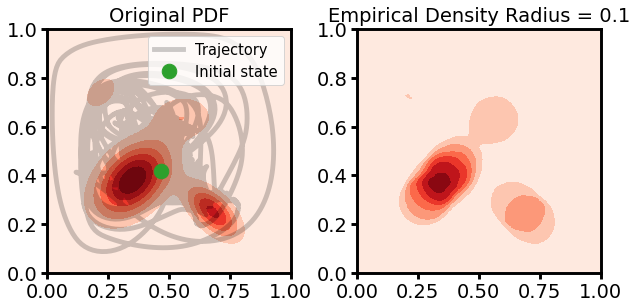

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
ax = axes[0]
ax.set_aspect('equal')
#ax.set_xlim(0.0, L_list[0])
#ax.set_ylim(0.0, L_list[1])
ax.set_title(f'Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10, 0], x_traj[::10, 1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0, 0], x_traj[0, 1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc='upper right')

ax2 = axes[1]
ax2.set_aspect('equal')
ax2.set_xlim(0.0, L_list[0])
ax2.set_ylim(0.0, L_list[1])
ax2.set_title(f'Empirical Density Radius = {r}')
ax2.contourf(grids_x_emp, grids_y_emp,
             empirical_density.reshape(grids_x_emp.shape),
             cmap='Reds')
plt.tight_layout()
plt.show()

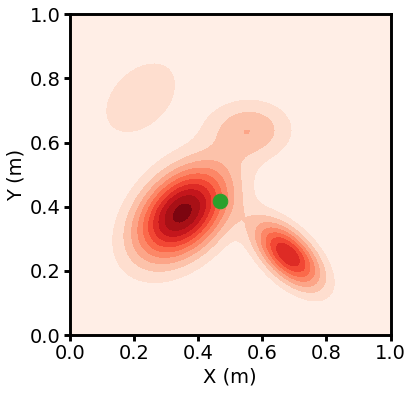

In [ ]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)